In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#  PO_Port Datei einlesen:
PO_Port = pd.read_csv("online_dataset_PO_Port_o2 .csv")
PO_Port

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,NaN
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-07,PO,Port,Port,529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-09,PO,Port,Port,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2023-01-30,PO,Port,Port,672,2023-01-30,2023-02-03,-,12.0,NaN,NaN,NaN,NaN,1.0
498,2022-03-21,PO,Port,Port,685,2022-03-21,2022-03-27,Einschränkung,12.0,NaN,NaN,NaN,NaN,1.0
499,2022-02-01,PO,Port,Port,773,2022-02-01,2022-02-05,Einschränkung,13.0,NaN,NaN,NaN,NaN,1.0
500,2023-04-05,PO,Port,Port,439,2023-04-05,2023-04-17,Einschränkung,13.0,NaN,NaN,NaN,NaN,1.0


In [3]:
PO_Port = PO_Port.sort_values(by='date')
PO_Port

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,NaN
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,2023-05-15,PO,Port,Port,374,2023-05-15,2023-05-17,-,3.0,NaN,NaN,NaN,NaN,1.0
223,2023-05-16,PO,Port,Port,210,2023-05-16,2023-05-17,-,NaN,NaN,NaN,NaN,NaN,1.0
387,2023-05-17,PO,Port,Port,129,2023-05-17,2023-05-17,Einschränkung,1.0,NaN,NaN,NaN,NaN,1.0
189,2023-05-18,PO,Port,Port,120,NaN,NaN,NaN,NaN,1.0,Christi Himmelfahrt,NaN,NaN,NaN


In [4]:
# Anzahl die ["incident_hours"]:
sales_sum = PO_Port["sales"].sum()

print(sales_sum)

309488


In [5]:

sum_sales_is_incident = PO_Port.loc[PO_Port['is_incident'] == 1, 'sales'].sum()

print(sum_sales_is_incident)

205049


Text(0, 0.5, 'Sales')

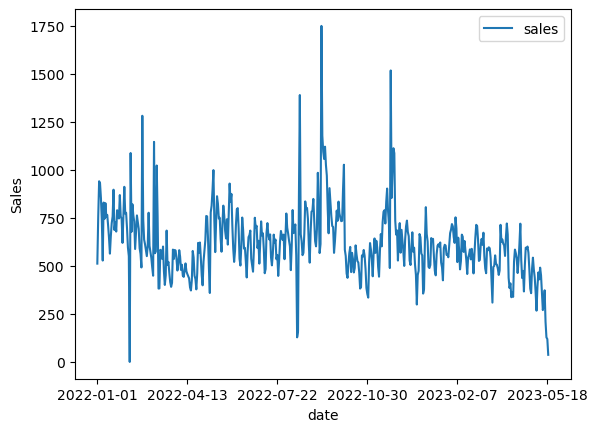

In [6]:
fig, ax = plt.subplots() # Create the figure and axes object
# Plot the first x and y axes:
PO_Port.plot(x = 'date', y = 'sales', ax = ax) 
plt.ylabel('Sales')

In [7]:
PO_Port.describe()

,sales,incident_days,is_holiday,is_release,is_incident
count,502.000000,219.000000,14.0,35.0,331.0
mean,616.509960,2.456621,1.0,1.0,1.0
std,178.873183,2.466601,0.0,0.0,0.0
min,1.000000,1.000000,1.0,1.0,1.0
25%,513.000000,1.000000,1.0,1.0,1.0
50%,597.500000,2.000000,1.0,1.0,1.0
75%,709.000000,3.000000,1.0,1.0,1.0
max,1751.000000,18.000000,1.0,1.0,1.0


In [8]:
PO_Port.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 0 to 190
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 502 non-null    object 
 1   product_category     502 non-null    object 
 2   reseller_name        502 non-null    object 
 3   reseller             502 non-null    object 
 4   sales                502 non-null    int64  
 5   incident_start_date  311 non-null    object 
 6   incident_end_date    311 non-null    object 
 7   incident_type        311 non-null    object 
 8   incident_days        219 non-null    float64
 9   is_holiday           14 non-null     float64
 10  holiday              14 non-null     object 
 11  release_type         35 non-null     object 
 12  is_release           35 non-null     float64
 13  is_incident          331 non-null    float64
dtypes: float64(4), int64(1), object(9)
memory usage: 58.8+ KB


In [9]:
PO_Port.describe()

,sales,incident_days,is_holiday,is_release,is_incident
count,502.000000,219.000000,14.0,35.0,331.0
mean,616.509960,2.456621,1.0,1.0,1.0
std,178.873183,2.466601,0.0,0.0,0.0
min,1.000000,1.000000,1.0,1.0,1.0
25%,513.000000,1.000000,1.0,1.0,1.0
50%,597.500000,2.000000,1.0,1.0,1.0
75%,709.000000,3.000000,1.0,1.0,1.0
max,1751.000000,18.000000,1.0,1.0,1.0


In [10]:
PO_Port.dtypes

date                    object
product_category        object
reseller_name           object
reseller                object
sales                    int64
incident_start_date     object
incident_end_date       object
incident_type           object
incident_days          float64
is_holiday             float64
holiday                 object
release_type            object
is_release             float64
is_incident            float64
dtype: object

In [11]:
print(PO_Port.isnull().sum())

date                     0
product_category         0
reseller_name            0
reseller                 0
sales                    0
incident_start_date    191
incident_end_date      191
incident_type          191
incident_days          283
is_holiday             488
holiday                488
release_type           467
is_release             467
is_incident            171
dtype: int64


# Erste Datensatz:   PO_Port:


## Datenvisualisierung: 

In [12]:
# Replace NaN values with 0
PO_Port["is_incident"].fillna(0, inplace=True)

# Convert the values to integers, removing decimals
PO_Port["is_incident"] = PO_Port["is_incident"].astype(int)

# Now you can check the value counts again
frq = PO_Port["is_incident"].value_counts(dropna=False)
print(frq)

is_incident
1    331
0    171
Name: count, dtype: int64


In [13]:
frq=PO_Port["date"].value_counts(dropna=False)
frq

date
2022-01-01    1
2022-11-29    1
2022-12-12    1
2022-12-11    1
2022-12-10    1
             ..
2022-06-14    1
2022-06-13    1
2022-06-12    1
2022-06-11    1
2023-05-19    1
Name: count, Length: 502, dtype: int64

In [14]:
#Change to datetime:
PO_Port["date"]= pd.to_datetime(PO_Port["date"])
# Konvertieren Sie die Spalte "date" in das gewünschte Monat-Jahr-Format und speichern Sie sie in einer neuen Spalte "Monat"
PO_Port['Monat'] = pd.to_datetime(PO_Port['date']).dt.to_period('M')
PO_Port.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,0,2022-01
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01
324,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01
325,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01


In [15]:
frq=PO_Port["is_holiday"].value_counts(dropna=False)
frq

is_holiday
NaN    488
1.0     14
Name: count, dtype: int64

In [16]:
PO_Port['is_incident'] = PO_Port['is_incident'].astype(str)

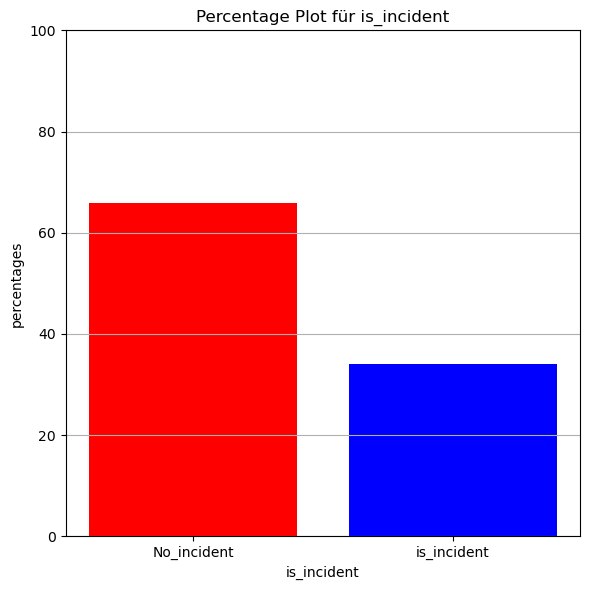

In [17]:
# Zählen Sie die Anzahl der 0 und 1 in der 'binary_var'-Spalte
is_incident_counts = PO_Port['is_incident'].value_counts()

# Berechnen Sie die Prozentsätze
total_samples = len(PO_Port)
percentages = is_incident_counts / total_samples * 100
colors = ['red', 'blue']
# Erstellen Sie den Plot
plt.figure(figsize=(6, 6))
plt.bar(percentages.index, percentages.values, color = colors)
plt.xlabel('is_incident')
plt.ylabel('percentages')
plt.title('Percentage Plot für is_incident')
plt.xticks(percentages.index, labels=['No_incident', 'is_incident'])
plt.ylim(0, 100)  # Stellen Sie die y-Achse auf 0 bis 100 ein
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
PO_Port['date'] = pd.to_datetime(PO_Port['date'])

# Extrahiere die Wochentage für jede Zeile in der "Datum"-Spalte
PO_Port['Wochentag'] = PO_Port['date'].dt.day_name()

# Drucke den DataFrame mit der neuen "Wochentag" Spalte
PO_Port.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,0,2022-01,Saturday
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01,Sunday
324,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01,Monday
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01,Tuesday
325,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01,Wednesday


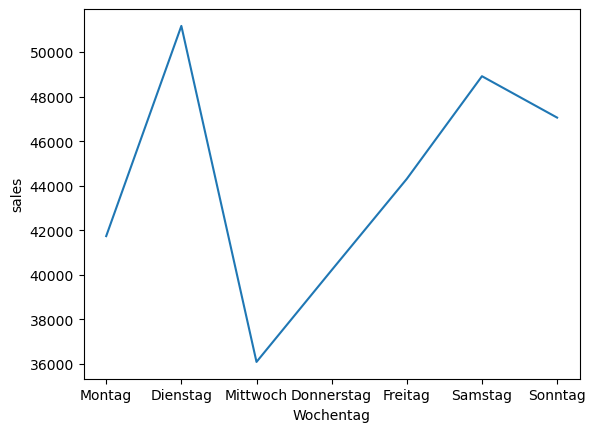

In [19]:
# Gruppieren Sie die Daten nach 'Wochentag' und berechnen Sie die Summe der Verkäufe für jeden Wochentag
Wochentag_group = PO_Port.groupby('Wochentag')
sales = Wochentag_group['sales'].sum()
Wochentags = [Wochentag for Wochentag, _ in Wochentag_group]

# Plot der Daten
plt.plot(Wochentags, sales)
plt.ylabel('sales')
plt.xlabel('Wochentag')
#plt.xticks(rotation='vertical', size=8)

# Hinzufügen der Wochentagsnamen als X-Achsenbeschriftungen
wochentag_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
plt.xticks(Wochentags, wochentag_names)

plt.show()

In [20]:
PO_Port['Monat'] = PO_Port['Monat'].dt.to_timestamp()


PO_Port['Monat'] = pd.to_datetime(PO_Port['Monat'])
PO_Port['month_name'] = PO_Port['Monat'].dt.strftime('%B')



# Convert the "Monat" to datetime data type if it's not already
PO_Port['Monat'] = pd.to_datetime(PO_Port['Monat'])

# Use dt.month to extract the month number and categorize based on month number (1 to 12)
PO_Port['Month_k'] = PO_Port['Monat'].dt.month

# Print the DataFrame with the new "Month_k" column
PO_Port

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,month_name,Month_k
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1.0,Neujahr,NaN,NaN,0,2022-01-01,Saturday,January,1
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01-01,Sunday,January,1
324,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01-01,Monday,January,1
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022-01-01,Tuesday,January,1
325,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2022-01-01,Wednesday,January,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,2023-05-15,PO,Port,Port,374,2023-05-15,2023-05-17,-,3.0,NaN,NaN,NaN,NaN,1,2023-05-01,Monday,May,5
223,2023-05-16,PO,Port,Port,210,2023-05-16,2023-05-17,-,NaN,NaN,NaN,NaN,NaN,1,2023-05-01,Tuesday,May,5
387,2023-05-17,PO,Port,Port,129,2023-05-17,2023-05-17,Einschränkung,1.0,NaN,NaN,NaN,NaN,1,2023-05-01,Wednesday,May,5
189,2023-05-18,PO,Port,Port,120,NaN,NaN,NaN,NaN,1.0,Christi Himmelfahrt,NaN,NaN,0,2023-05-01,Thursday,May,5


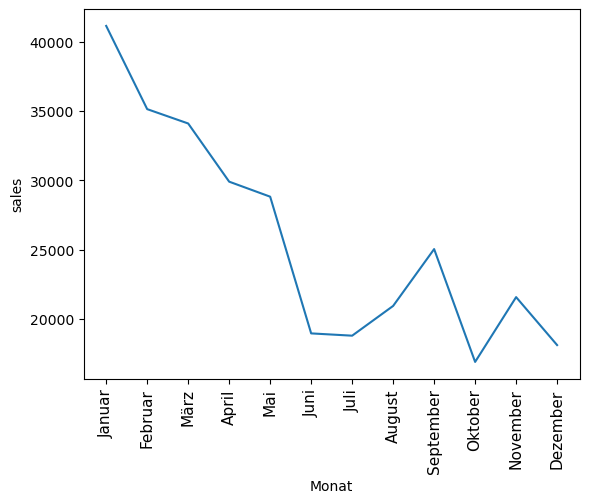

In [21]:
def get_month_name(month_num):
    months = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']
    return months[month_num - 1]  # Monatsnummern sind 1-basiert, daher müssen wir 1 abziehen

Monat_group = PO_Port.groupby('Month_k')
sales = Monat_group['sales'].sum()
Monats = [get_month_name(month_num) for month_num in sales.index]

plt.plot(Monats, sales)
plt.ylabel('sales')
plt.xlabel('Monat')
plt.xticks(rotation='vertical', size=11)
plt.show()

In [22]:
# Replace NaN values with 0
PO_Port["is_holiday"].fillna(0, inplace=True)

# Convert the values to integers, removing decimals
PO_Port["is_holiday"] = PO_Port["is_holiday"].astype(int)

# Now you can check the value counts again
frq = PO_Port["is_holiday"].value_counts(dropna=False)
print(frq)

is_holiday
0    488
1     14
Name: count, dtype: int64


In [23]:
PO_Port['is_holiday'] = PO_Port['is_holiday'].astype(str)

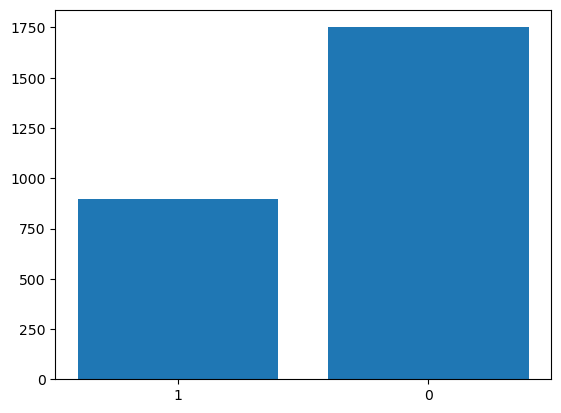

In [24]:
plt.bar(PO_Port['is_holiday'],PO_Port['sales'])
plt.show()

In [25]:
PO_Port.columns

Index(['date', 'product_category', 'reseller_name', 'reseller', 'sales',
       'incident_start_date', 'incident_end_date', 'incident_type',
       'incident_days', 'is_holiday', 'holiday', 'release_type', 'is_release',
       'is_incident', 'Monat', 'Wochentag', 'month_name', 'Month_k'],
      dtype='object')

In [26]:
# Erstellen Sie die Dummy-Variablen für "is_holiday"
holiday_dummies = pd.get_dummies(PO_Port['is_holiday'], prefix='Holiday', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "is_incident"
incident_dummies = pd.get_dummies(PO_Port['is_incident'], prefix='Incident', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "Wochentag"
weekday_dummies = pd.get_dummies(PO_Port['Wochentag'], prefix='Weekdays', drop_first=True)

# Erstellen Sie die Dummy-Variablen für "Month_k"
month_dummies = pd.get_dummies(PO_Port['Month_k'], prefix='Month', drop_first=True)

# Fügen Sie die Dummy-Variablen dem DataFrame hinzu
PO_Port = pd.concat([PO_Port, holiday_dummies, incident_dummies, weekday_dummies, month_dummies], axis=1)

PO_Port.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,month_name,Month_k,Holiday_1,Incident_1,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Thursday,Weekdays_Tuesday,Weekdays_Wednesday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1,Neujahr,NaN,NaN,0,2022-01-01,Saturday,January,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Sunday,January,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
324,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Monday,January,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Tuesday,January,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
325,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Wednesday,January,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [27]:
# Daten PO_Port speichern:
PO_Port.to_csv("PO_Port.csv", index = None)

In [31]:
# Daten PO_Port einlesen:

PO_Port=pd.read_csv("PO_Port.csv")
PO_Port.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,holiday,release_type,is_release,is_incident,Monat,Wochentag,month_name,Month_k,Holiday_1,Incident_1,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Thursday,Weekdays_Tuesday,Weekdays_Wednesday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1,Neujahr,NaN,NaN,0,2022-01-01,Saturday,January,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Sunday,January,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Monday,January,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2022-01-01,Tuesday,January,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,0,NaN,NaN,NaN,1,2022-01-01,Wednesday,January,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [32]:
PO_Port.columns

Index(['date', 'product_category', 'reseller_name', 'reseller', 'sales',
       'incident_start_date', 'incident_end_date', 'incident_type',
       'incident_days', 'is_holiday', 'holiday', 'release_type', 'is_release',
       'is_incident', 'Monat', 'Wochentag', 'month_name', 'Month_k',
       'Holiday_1', 'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday',
       'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday',
       'Weekdays_Wednesday', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12'],
      dtype='object')

# Regression: 

In [34]:
# Definiere die unabhängigen Variablen (X) und die abhängige Variable (y)
X = PO_Port[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]]  
y = PO_Port['sales']

# Füge eine Konstante hinzu, um den Intercept zu berücksichtigen
X = sm.add_constant(X)

# Erstelle und fitte das Regressionsmodell
model = sm.OLS(y, X).fit()
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const                 float64
Holiday_1                bool
Incident_1               bool
Weekdays_Monday          bool
Weekdays_Saturday        bool
Weekdays_Sunday          bool
Weekdays_Thursday        bool
Weekdays_Tuesday         bool
Weekdays_Wednesday       bool
Month_2                  bool
Month_3                  bool
Month_4                  bool
Month_5                  bool
Month_6                  bool
Month_7                  bool
Month_8                  bool
Month_9                  bool
Month_10                 bool
Month_11                 bool
Month_12                 bool
dtype: object. The data was
0      513
1      757
2      942
3      932
4      855
      ... 
497    374
498    210
499    129
500    120
501     38
Name: sales, Length: 502, dtype: int64
and
      const  Holiday_1  Incident_1  ...  Month_10  Month_11  Month_12
0      1.0       True       False  ...     False     False     False
1      1.0      False       False  ...     False     False     False
2      1.0      False        True  ...     False     False     False
3      1.0      False       False  ...     False     False     False
4      1.0      False        True  ...     False     False     False
..     ...        ...         ...  ...       ...       ...       ...
497    1.0      False        True  ...     False     False     False
498    1.0      False        True  ...     False     False     False
499    1.0      False        True  ...     False     False     False
500    1.0       True       False  ...     False     False     False
501    1.0      False       False  ...     False     False     False

[502 rows x 20 columns]
before. After,
[ 513  757  942  932  855  737  529  831  746  828  756  767  711  646
  565  656  724  759  898  688  729  680  791  773  748  870  759  746
  621  775  913  773  778  696  597  552    1 1089  679  822  765  732
  589  677  764  730  694  593  564  493 1283  743  638  614  583  552
  606  778  605  575  543  493  450 1147  567  576 1024  759  383  384
  585  580  538  602  473  402  452  685  506  522  465  416  392  413
  586  537  584  581  536  477  514  583  549  480  507  450  444  478
  514  473  459  447  436  389  373  426  579  545  450  433  379  463
  621  570  623  543  452  400  524  582  634  761  759  642  489  360
  780  815  896 1000  740  573  733  864  825  748  752  643  575  719
  815  764  684  644  744  612  768  930  836  876  712  592  522  580
  714  797  802  698  538  503  609  753  688  591  595  524  441  575
  651  661  685  538  503  471  590  752  699  710  594  632  513  629
  733  659  671  587  463  485  674  724  663  639  665  545  504  565
  664  621  638  536  558  449  530  627  683  658  636  664  536  648
  774  700  670  633  603  479  608  792  672  691  717  555  129  161
  866 1391  666  631  557  569  670  837  797  803  746  610  518  679
  784  788  850  742  630  603  692  986  829  568  615 1751 1179 1096
 1058 1122 1027  971  796  671  906  836  760  709  704  569  629  709
  789  736  836  775  752  734  736  899 1028  585  553  461  439  510
  568  600  469  569  538  467  490  608  561  526  519  467  383  391
  556  549  584  553  486  386  355  336  522  620  585  532  447  566
  644  569  632  597  497  445  580  667  603  728  783  791  722  835
  904  788  722  490 1519  855  998 1114 1088  737  664  686  529  662
  724  570  689  634  578  501  638  707  737  678  656  529  506  600
  676  575  596  507  454  300  454  475  667  650  566  556  357  380
  631  807  667  628  496  490  506  646  638  642  550  475  452  561
  606  614  601  623  519  493  426  594  611  607  559  561  546  608
  672  690  719  707  651  621  754  695  521  648  585  483  527  664
  653  574  631  582  530  459  545  560  587  535  590  546  462  563
  649  715  709  638  527  532  611  642  611  674  553  487  463  592
  582  598  593  543  420  310  496  501  556  512  507  487  454  477
  715  627  639  617  608  553  652  722  664  439  386  410  338  365
  340  524  586  567  541  464  528  615  721  532  438  475  368  503
  596  591  602  570  484  383  359  485  544  482  441  363  268  390
  467  431  492  452  356  271  302  374  210  129  120   38]
[[1.0 True False ... False False False]
 [1.0 False False ... False False False]
 [1.0 False True ... False False False]
 ...
 [1.0 False True ... False False False]
 [1.0 True False ... False False False]
 [1.0 False False ... False False False]].

# ARIMAX:

In [64]:
exog= PO_Port[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]]  
endog= PO_Port['sales']

# Create the ARIMA model with AR order = 1 and MA order = 0 and provide exogenous variables
order = (1, 1, 1)  # AR order = 1, MA order = 0
model = sm.tsa.ARIMA(endog, exog, order=order)

# Fit the model to the data
results = model.fit()

# Display the results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  502
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3121.067
Date:                Thu, 27 Jul 2023   AIC                           6286.134
Time:                        15:22:14   BIC                           6378.899
Sample:                             0   HQIC                          6322.532
                                - 502                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Holiday_1           -106.7237     46.741     -2.283      0.022    -198.334     -15.113
Incident_1            -2.7459     13.238     -0.207      0.836     -28.693      23.201
Weekdays_Monday     

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Prognose:

In [65]:
# Define the exogenous features for forecasting
#exogenous_features = PO_Port[['is_incident', 'Month_k', 'Wochentag', 'is_holiday']]
exogenous_features= PO_Port[['Holiday_1', 'Incident_1', 
             'Weekdays_Monday','Weekdays_Saturday','Weekdays_Sunday','Weekdays_Thursday','Weekdays_Tuesday','Weekdays_Wednesday',
             'Month_2', 'Month_3', 'Month_4', 'Month_5','Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Month_12' ]]  

# Generate the forecast for the entire data period
forecast = results.predict(exog=exogenous_features)

# Add the forecasted values to the DataFrame
PO_Port["Forecast_ARIMAX"] = forecast

# Print the DataFrame with the forecasted values
PO_Port.head()

,date,product_category,reseller_name,reseller,sales,incident_start_date,incident_end_date,incident_type,incident_days,is_holiday,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,sales_forecast_Regression,Forecast_ARIMAX
0,2022-01-01,PO,Port,Port,513,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,444.642839,-201.208106
1,2022-01-02,PO,Port,Port,757,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,631.295608,699.057664
2,2022-01-03,PO,Port,Port,942,2022-01-03,2022-01-03,Einschränkung,1.0,0,...,0,0,0,0,0,0,0,0,764.347742,870.336569
3,2022-01-04,PO,Port,Port,932,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,731.966966,865.622386
4,2022-01-05,PO,Port,Port,855,2022-01-05,2022-01-05,Einschränkung,1.0,0,...,0,0,0,0,0,0,0,0,698.163265,865.441796


<AxesSubplot:>

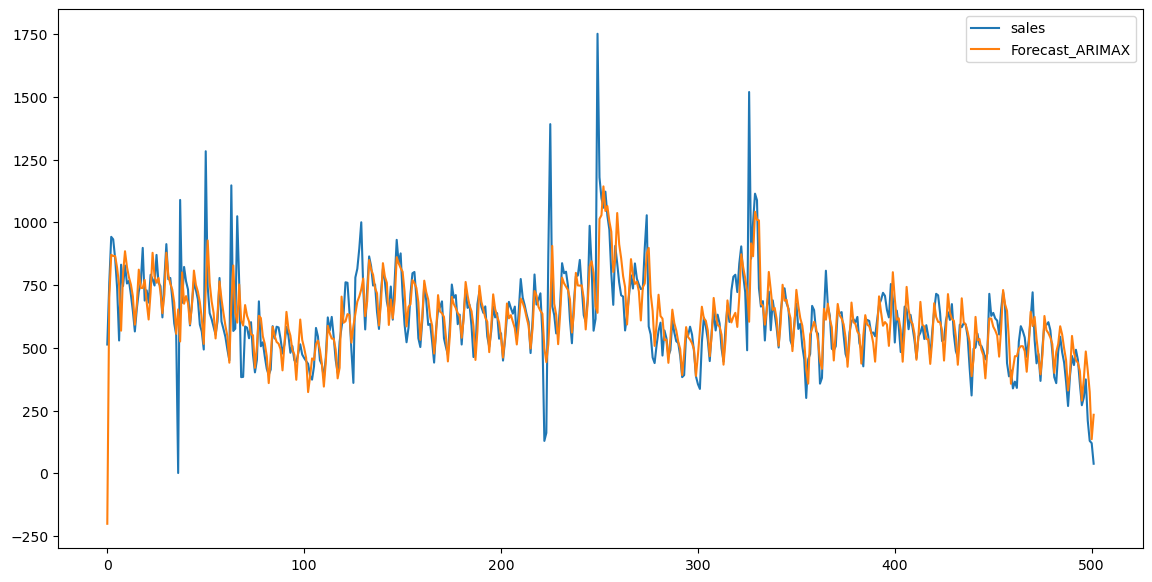

In [61]:
PO_Port[["sales", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

# Optimierung ARIMAX:

In [66]:
# Assuming your dataset "PO_Port" has a column named "sales" representing the time series data
# Replace 'sales' with the actual column name if different
data = PO_Port['sales']

#data = PO_Port[['sales', 'Holiday_1', 'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]


# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                           order=comb,
                                           seasonal_order=combs,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
print(ans_df.loc[ans_df['aic'].idxmin()])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7901.475723715164
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7311.895674605506
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6673.313537239444
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =6330.803624638032
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6665.979987161141
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6479.464017778371
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =6437.397681737341
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6328.247804795747
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7384.021963450148
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6979.884489505001
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6584.5580389728675
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6187.559802391074
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6582.397575640007
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6334.2872748536165
ARIMA (0, 0, 1) x 

In [68]:
import pandas as pd
import statsmodels.api as sm

# Assuming your dataset "PO_Port" has a column named "sales" representing the time series data
# Replace 'sales' with the actual column name if different
data = PO_Port['sales']

# Define the exogenous variables (including the constant if needed)
exog_variables = PO_Port[['Holiday_1', 'Incident_1', 'Weekdays_Monday', 'Weekdays_Saturday', 'Weekdays_Sunday', 'Weekdays_Thursday', 'Weekdays_Tuesday', 'Weekdays_Wednesday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]
exog_variables = sm.add_constant(exog_variables)  # If you need a constant term

# Create the SARIMAX model with AR order = 1, MA order = 0, and seasonal order = (0, 1, 1, 12)
order = (1, 1, 1)  # AR order = 1, MA order = 0
seasonal_order = (0, 1, 1, 12)  # Seasonal order (P, D, Q, S) = (0, 1, 1, 12)
model = sm.tsa.SARIMAX(data, exog=exog_variables, order=order, seasonal_order=seasonal_order)

# Fit the model to the data
results = model.fit()

# Display the results
print(results.summary())

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  502
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3067.421
Date:                            Thu, 27 Jul 2023   AIC                           6182.842
Time:                                    15:26:23   BIC                           6283.458
Sample:                                         0   HQIC                          6222.361
                                            - 502                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1019   7804.262   1.31e-05      1.000   -1.53e+04    1.53e+04
Holiday_1  